### Step 4
Do the same as Step 3 when instead a context-generation approach is adopted to identify the classes of customers and adopt a potentially different pricing strategy per class. In doing that, evaluate the performance of the pricing strategies in the different classes only at the optimal solution (e.g., if prices that are not optimal for two customers’ classes provide different performance, you do not split the contexts). Let us remark that no discrimination of the customers’ classes is performed at the advertising level. From this Step on, choose one approach between the upper-confidence bound one and the Thompson-sampling one.

### Main for the experiment

Here data is NOT aggregated

In [1]:
import numpy as np
from environment import Environment
from learners.ucb_learner import UCB1
from learners.ts_learner import TS_Learner


env = Environment()
n_arms = 13
ucb1_learner_c0 = UCB1(n_arms = n_arms)
ucb1_learner_c1 = UCB1(n_arms = n_arms)
ucb1_learner_c2 = UCB1(n_arms = n_arms)
ts_learner_c0 = TS_Learner(n_arms = n_arms)
ts_learner_c1 = TS_Learner(n_arms = n_arms)
ts_learner_c2 = TS_Learner(n_arms = n_arms)

T = 365
opt_bids = [3.8622484787564275 , 2.1216094606111944,  2.347134281066495]
opt_price = 6.321089806558111
regret_c0_ucb = []
regret_c1_ucb = []
regret_c2_ucb = []

regret_c0_ts = []
regret_c1_ts = []
regret_c2_ts = []

# Use this for testing, the price learned is 7, the optimal one
bids = opt_bids 
prices = np.linspace(3.0, 15.0, n_arms)

price_ev_per_day_ucb = []
price_ev_per_day_ts = []

for day in range(T):
    #UCB1 learner
    price_c0_idx = ucb1_learner_c0.pull_arm()
    price_c0 = prices[price_c0_idx]
    price_c1_idx = ucb1_learner_c1.pull_arm()
    price_c1 = prices[price_c1_idx]
    price_c2_idx = ucb1_learner_c2.pull_arm()
    price_c2 = prices[price_c2_idx]
    
    reward_per_day = []
    price = [price_c0, price_c1, price_c2]
    for i in range(len(price)):
        p = price[i]
        reward = env.round(bids, p)
        reward_per_day.append(reward[i]) 

    ucb1_learner_c0.update(price_c0_idx, reward_per_day[0])
    ucb1_learner_c1.update(price_c1_idx, reward_per_day[1])
    ucb1_learner_c2.update(price_c2_idx, reward_per_day[2])
    
    reward_optimal = env.round(opt_bids, opt_price, noise= False)
    regret_c0 = reward_optimal[0] - reward_per_day[0]
    regret_c1 = reward_optimal[1] - reward_per_day[1]
    regret_c2 = reward_optimal[2] - reward_per_day[2]
    regret_c0_ucb.append(regret_c0)
    regret_c1_ucb.append(regret_c1)
    regret_c2_ucb.append(regret_c2)

    price_ev_per_day_ucb.append(price)

    #TS learner
    price_c0_idx = ts_learner_c0.pull_arm()
    price_c0 = prices[price_c0_idx]
    price_c1_idx = ts_learner_c1.pull_arm()
    price_c1 = prices[price_c1_idx]
    price_c2_idx = ts_learner_c2.pull_arm()
    price_c2 = prices[price_c2_idx]
    
    reward_per_day = []
    price = [price_c0, price_c1, price_c2]
    for i in range(len(price)):
        p = price[i]
        reward = env.round(bids, p)
        reward_per_day.append(reward[i]) 

    ts_learner_c0.update(price_c0_idx, reward_per_day[0])
    ts_learner_c1.update(price_c1_idx, reward_per_day[1])
    ts_learner_c2.update(price_c2_idx, reward_per_day[2])
    
    reward_optimal = env.round(opt_bids, opt_price, noise= False)
    regret_c0 = reward_optimal[0] - reward_per_day[0]
    regret_c1 = reward_optimal[1] - reward_per_day[1]
    regret_c2 = reward_optimal[2] - reward_per_day[2]
    regret_c0_ts.append(regret_c0)
    regret_c1_ts.append(regret_c1)
    regret_c2_ts.append(regret_c2)

    price_ev_per_day_ts.append(price)


## Plots

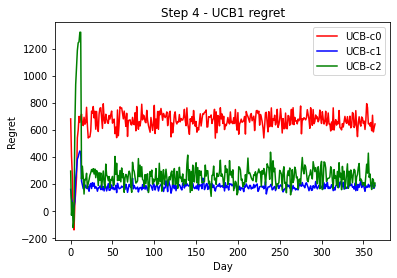

In [2]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("Day")
plt.ylabel("Regret")
plt.plot(regret_c0_ucb,'r', label="UCB-c0")
plt.plot(regret_c1_ucb, 'b', label="UCB-c1")
plt.plot(regret_c2_ucb, 'g', label="UCB-c2")
plt.title("Step 4 - UCB1 regret")
plt.legend()
plt.show()


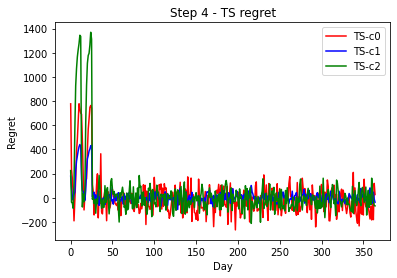

In [3]:
import matplotlib.pyplot as plt 

plt.figure(1)
plt.xlabel("Day")
plt.ylabel("Regret")
plt.plot(regret_c0_ts,'r', label="TS-c0")
plt.plot(regret_c1_ts, 'b', label="TS-c1")
plt.plot(regret_c2_ts, 'g', label="TS-c2")
plt.title("Step 4 - TS regret")
plt.legend()
plt.show()

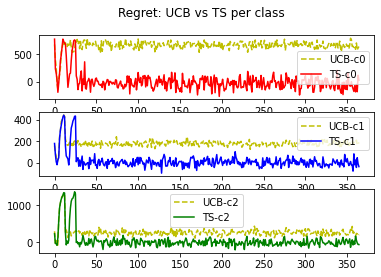

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
fig.suptitle('Regret: UCB vs TS per class')
axs[0].plot(regret_c0_ucb,'y', label="UCB-c0", linestyle="dashed")
axs[0].plot(regret_c0_ts,'r', label="TS-c0")
axs[0].legend()
axs[1].plot(regret_c1_ucb,'y', label="UCB-c1", linestyle="dashed")
axs[1].plot(regret_c1_ts,'b', label="TS-c1")
axs[1].legend()
axs[2].plot(regret_c2_ucb,'y', label="UCB-c2", linestyle="dashed")
axs[2].plot(regret_c2_ts,'g', label="TS-c2")
axs[2].legend()

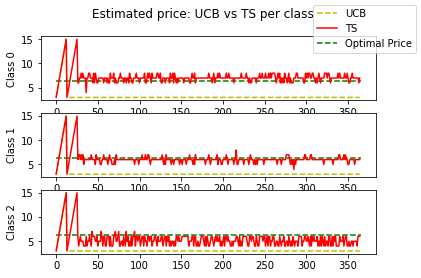

In [5]:
import matplotlib.pyplot as plt
import numpy as np

YY_ucb = np.array(price_ev_per_day_ucb) 
YY_ts = np.array(price_ev_per_day_ts)

fig, axs = plt.subplots(3)
fig.suptitle('Estimated price: UCB vs TS per class')
axs[0].plot(YY_ucb[:,0],'y', linestyle="dashed")
axs[0].plot(YY_ts[:,0],'r')
axs[0].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[0].set(ylabel="Class 0")
axs[1].plot(YY_ucb[:,1],'y', linestyle="dashed")
axs[1].plot(YY_ts[:,1],'r')
axs[1].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[1].set(ylabel="Class 1")
axs[2].plot(YY_ucb[:,2],'y', linestyle="dashed")
axs[2].plot(YY_ts[:,2],'r')
axs[2].hlines(opt_price, 0, 365, 'g', linestyles='dashed')
axs[2].set(ylabel="Class 2")
fig.legend(["UCB","TS","Optimal Price"])

In [6]:
regret_c0_ts[-10:]


[2.7992135671711367,
 -78.8091102208407,
 -128.45163886124624,
 -176.07418935992428,
 -70.67764281950735,
 -184.13712184150563,
 -48.23964751129961,
 -181.46461529181965,
 118.69137344305068,
 26.710789696109714]

In [7]:
regret_c1_ts[-10:]

[-21.32593732337324,
 -23.05112502862545,
 -78.87810367175143,
 81.35440215120587,
 -19.479601529567674,
 24.321189647204847,
 -44.76282082762032,
 45.53431713789945,
 -10.590588430740922,
 -36.92031476716738]

In [8]:
regret_c2_ts[-10:]

[-12.51155719615383,
 61.91006615726508,
 -78.24204191178012,
 26.12393866209709,
 -58.19113913735225,
 161.69672274486118,
 50.674392865948676,
 -22.572217222263475,
 -65.18210960534395,
 -67.49714302453742]